# Raghav Gupta

February 2021

ML Model using MNIST Dataset

## Section 0: Loading the data


In [ ]:
import keras
import numpy as np
import scipy.misc
import cv2
import json
import matplotlib.pyplot as plt
from sklearn.datasets import load_files
from keras.datasets import mnist
from keras import applications
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers import Dropout, Flatten, Lambda, Dense, Activation
from keras.models import Model, Sequential
from keras.utils import np_utils
from keras.preprocessing import image    
from matplotlib import pyplot
#from scipy.misc import toimage
from tqdm import tqdm
from glob import glob
from PIL import Image
from skimage.util import random_noise
from skimage import exposure


In [ ]:
num_classes = 10

(X_train, y_train), (X_test, y_test) = mnist.load_data()
print('x_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Normalize Data
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

11493376/11490434 [==============================] - 0s 0us/step
x_train shape: (60000, 28, 28)
60000 train samples
10000 test samples


Visualizing 9 of the images in the data.

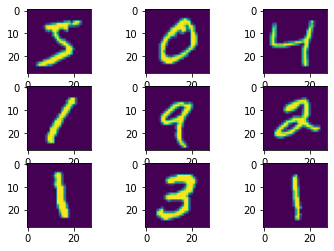

In [ ]:
for i in range(0, 9):
    pyplot.subplot(330 + 1 + i)
    pyplot.imshow(X_train[i])
# show the plot
pyplot.show()

## Section 1: Data augmentation

In [ ]:
def example_augment(img):
    augmented_img = np.fliplr(img)
    return augmented_img

**Augmentation Explanation:** In this augmentation I use the skimage library to add random noise to the image.

In [ ]:
def augmentation_1(img):   
    augmented_img = random_noise(img)
    return augmented_img

**Augmentation Explanation:** Use the skimage library to add gamma correction to the image. 

In [ ]:
def augmentation_2(img):
    augmented_img = exposure.adjust_gamma(img, gamma=0.4, gain=0.9)
    return augmented_img

Visualizing your augmentations.

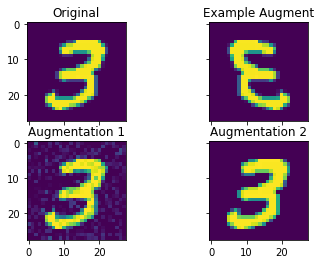

In [ ]:
sample_img = X_train[7]
f, axarr = plt.subplots(2, 2)
axarr[0, 0].imshow(sample_img)
axarr[0, 0].set_title('Original')
axarr[0, 1].imshow(example_augment(sample_img))
axarr[0, 1].set_title('Example Augment')
axarr[1, 0].imshow(augmentation_1(sample_img))
axarr[1, 0].set_title('Augmentation 1')
axarr[1, 1].imshow(augmentation_2(sample_img))
axarr[1, 1].set_title('Augmentation 2')

for ax in axarr.flat:
    ax.label_outer()

In [ ]:
NB_AUGMENTATIONS = 0
# Don't change this for MNIST.
IMG_SIZE = 28

def batch_generator(images, labels, augment=True, batch_size=32):
    batch_images = []
    batch_labels = []
    sample_count = 0
    
    while True:
        # Shuffle indices to minimize overfitting.
        for i in np.random.permutation(images.shape[0]):

            img = images[i]
            img = np.expand_dims(img, axis=3)
            label = labels[i]

            batch_images.append(img)
            batch_labels.append(label)
            sample_count += 1

            if augment:
                # Perform Augmentation (Flipping the Image)
                img_example_augment = example_augment(img)
                batch_images.append(img_example_augment)
                batch_labels.append(label)
                
                # Perform Augmentation 1
                img_augment_1 = augmentation_1(img)
                batch_images.append(img_augment_1)
                batch_labels.append(label)

                # Perform Augmentation 2
                img_augment_2 = augmentation_2(img)
                batch_images.append(img_augment_2)
                batch_labels.append(label)

            if ((sample_count % batch_size == 0) or (sample_count % len(images) == 0)):
                yield np.array(batch_images), np.array(batch_labels)
                # Reset batch.
                batch_images = []
                batch_labels = []

## Section 2: Building the model

**Explanation:** The Model consists of a 2D convolutional layer which takes an input of (28,28,1). It is followed by Max pooling which pools the sum of the previous convoluted result. It is followed by drouput and then a similar set of layers but with more filters. This shrinks the image down to a smaller vector and gives us higher accuracy. 

Finally the result is put through a flatten which converts the image to a vector which is passed through a dense layer and then finally a 10 ouput softmax activation dense layer for classification.

In [ ]:
model = Sequential()

model.add(Conv2D(32,(3,3), input_shape=(28,28,1),activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Dropout(0.2))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dense(10,activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 32)          0         
_________________________________________________________________
dropout (Dropout)            (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 6, 64)          18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               3

In [ ]:
# # FOR YOU TO CHOOSE
optimizer = 'adam'
loss = 'categorical_crossentropy'

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

## Section 3: Training the model


In [ ]:
generator_train = batch_generator(X_train, y_train, augment=False)

X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

history = model.fit(X_train, y_train, epochs =20, verbose = 1,batch_size = 64)
# Save the weights for grading.
model.save_weights('modelMIST.h5', True)
with open('model.json', 'w') as outfile:
    json.dump(model.to_json(), outfile)

Epoch 1/20
938/938 [==============================] - 28s 29ms/step - loss: 0.6388 - accuracy: 0.7990
Epoch 2/20
938/938 [==============================] - 27s 29ms/step - loss: 0.0843 - accuracy: 0.9738
Epoch 3/20
938/938 [==============================] - 27s 29ms/step - loss: 0.0566 - accuracy: 0.9822
Epoch 4/20
938/938 [==============================] - 27s 29ms/step - loss: 0.0471 - accuracy: 0.9859
Epoch 5/20
938/938 [==============================] - 27s 29ms/step - loss: 0.0378 - accuracy: 0.9884
Epoch 6/20
938/938 [==============================] - 27s 29ms/step - loss: 0.0341 - accuracy: 0.9888
Epoch 7/20
938/938 [==============================] - 27s 29ms/step - loss: 0.0316 - accuracy: 0.9896
Epoch 8/20
938/938 [==============================] - 27s 29ms/step - loss: 0.0250 - accuracy: 0.9915
Epoch 9/20
938/938 [==============================] - 27s 29ms/step - loss: 0.0215 - accuracy: 0.9931
Epoch 10/20
938/938 [==============================] - 27s 29ms/step - loss: 0.022

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy'])


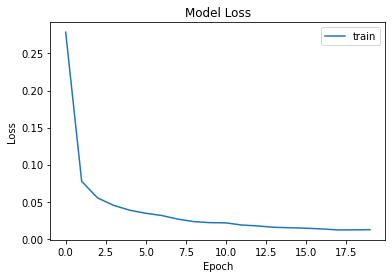

In [ ]:
# Summarize history for loss
plt.plot(history.history['loss'])
#plt.plot(history.history['acc'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train'], loc='upper right')
plt.show()

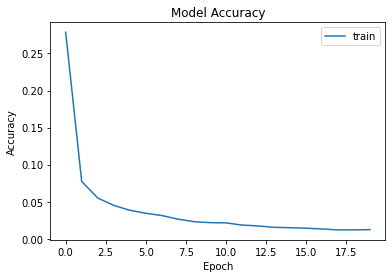

In [ ]:
# Summarize history for accuracy
plt.plot(history.history['loss'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train'], loc='upper right')
plt.show()

## Section 4: Evaluation

A confusion matrix would be ideal but since there are so many classes it will be hard to cleanly visualize. Instead f1, precision, and recall scores for each class would be cleaner to read.

First, I included a percision report which includes the percision and f1 score of each digit. The accuracy of the model is 98.5% which is impressive. After this I plot a confusion matrix which shows the accuracy of matching for the 10 classes. It shows the highest accuracy in predicting 1 and lowest for 5. Also it shows the amount of times it mismatches the test data to the wrong class. It is low, the highest being for 7 being misunderstood for 2.

In [ ]:
score = model.evaluate(X_test,y_test,verbose=False)

y_pred = model.predict(X_test)
y_test_class = np.argmax(y_test,axis=1)
y_pred_class = np.argmax(y_pred,axis=1)

print("Accurary: %.4f%%" %(score[1]*100))

Accurary: 99.1500%


In [ ]:
import itertools
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print(classification_report(y_test_class,y_pred_class))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.99      1.00      0.99      1032
           3       1.00      0.99      0.99      1010
           4       0.99      1.00      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.98      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.98      0.99       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


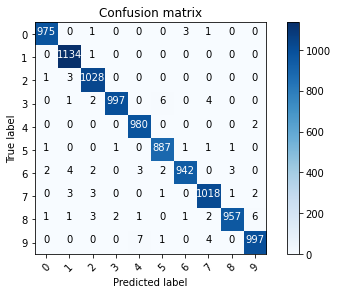

In [ ]:
cnf_matrix = confusion_matrix(y_test_class,y_pred_class)
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['0','1','2','3','4','5','6','7','8','9'], title='Confusion matrix')

\* Project Code inspired and taken from Udacity's AI Nanodegress https://github.com/mahavird/dog-project. All credit for the helper methods to load the dataset goes to Udacity.